# Introduction

In [2]:
from datetime import datetime
import pandas as pd
import numpy as np

# Stats
import statsmodels.tsa.stattools # for ADF test and coint function
import statsmodels.api # for OLS

# from scipy.stats import norm  # to fit normal dist to data
# import matplotlib.mlab as mlab  # to generate pdfs

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

This report summarises and demonstrates some of the techniques used at arriving at trading strategies using the concepts of _stationarity_ and _cointegration_. In particular, the focus is on energy commodities.

* Section 1 provides details for the datasets used throughout the report
* Section 2 introduces the concept of Stationarity in time series, which  is the key property exploited by cointegration techniques and mean-reverting strategies
* Section 3 goes in detail about Cointegration and how to test for it, as well as assesing its significance
* Section 4 is then dedicated to the application of these concepts to trading strategies and assesing their performance in terms of profit and loss
* Finally the Appendix summarises some of the mathematical methods involved such as Multivariate Regression models (VAR(p), ECM, Augmented Dickey-Fuller Test and Ornstein–Uhlenbeck processes

# Datasets

## Simulated Data

Unless otherwise stated, stochastic processes are simulated with Monte Carlo (MC) where random samples are drawn from the normal distribution.

## Real Data

* For simplicity, only two finacial series are used to demonstrate the concepts. As the focus is on energy commodities, Brent crude and a byproduct (Low Sulphur Gasoil) were selected since they were assumed to be good candidates to demonstrate cointegration 
* The [Brent](https://www.theice.com/products/219/Brent-Crude-Futures) and [Gasoil](https://www.theice.com/products/34361119/Low-Sulphur-Gasoil-Futures) Futures prices traded in the Intercontinental Exchange (ICE) were taken from  [Quandl's Steven Continuous Series](https://www.quandl.com/data/SCF/documentation/about) using the 'Roll on Last Trading Day with No Price Adjustment' version and the 'Settle' field
* The two series were joined to produce a single dataset consisting of daily settlement prices for Brent and Gasoil from January 2010 to June 2016
* Dates with missing values after joining the two series were dropped
* Since Gasoil is traded in metric tons and Brent in barrels, the gasoil series was divided by 7.45, which is the [ICE conversion factor](https://www.theice.com/publicdocs/futures/ICE_Gas_Oil_Crack.pdf)

The figure below shows the resulting dataset, where the two series indeed seem to be closely related and having with parallel up and down trends.

            brent     gasoil
Date                        
2010-01-04  80.12  87.751678
2010-01-05  80.59  88.489933
2010-01-06  81.89  88.825503
2010-01-07  81.51  88.624161
2010-01-08  81.37  88.087248
            brent     gasoil
Date                        
2016-06-24  48.41  58.389262
2016-06-27  47.16  56.476510
2016-06-28  48.58  57.516779
2016-06-29  50.61  60.402685
2016-06-30  49.68  59.395973


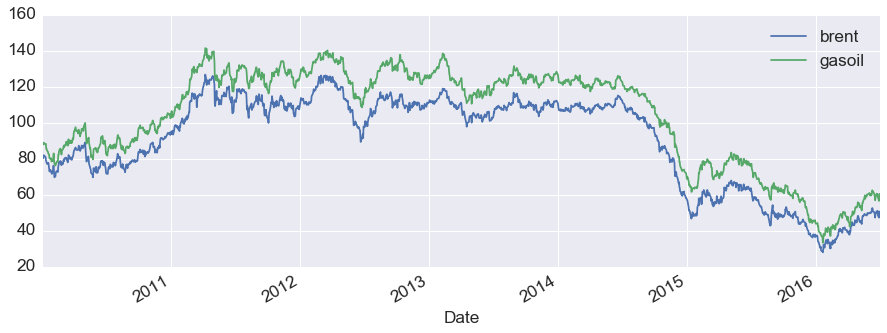

In [11]:
temp = pd.read_csv("data/df_brent_gasoil.csv", index_col=0, parse_dates=True, dayfirst=True)
df = temp[temp.index > datetime(2010, 1, 1)]
print df.head()
print df.tail()
_ = df.plot()

# Stationarity and Mean-Reversion

Before cointegration is introduced, it is important to understand the concept of stationarity. A time series is stationary when the parameters of its generating process do not change over time. In particular, its long-run mean and variance stay constant. This property is fundamental when applying linear regression and forecasting models.

Often, processes with a drift or trend, like stock prices, are non-stationary but can be transformed to become stationary. For example, by differencing prices we get returns, which are in general stationary.

The figure below shows how a simulated random walk with drift $Y_t = \alpha + Y_{t-1} + \epsilon_t$ can be made stationary by differencing $Y_t - Y_{t-1} = \alpha + \epsilon_t$

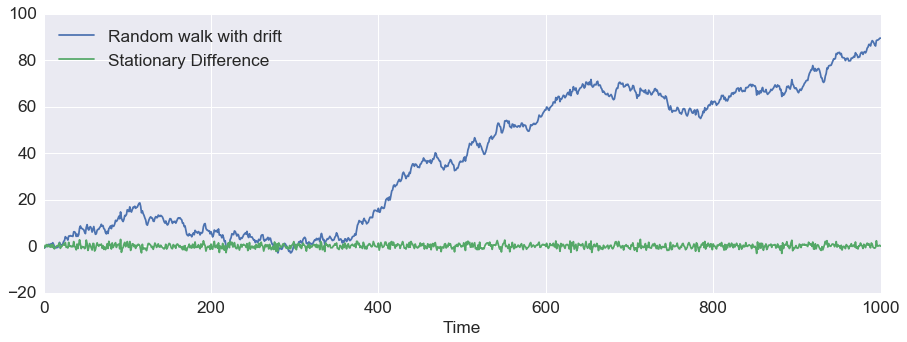

In [4]:
np.random.seed(1000)  # set the seed
M = 1000  # no. of time steps
Y_t = np.zeros((M + 1))
Y_t[0] = 0.0  # initial value
a = 0.1  # drift

for i in xrange(1, M + 1, 1):
    Y_t[i] = a + Y_t[i-1] + np.random.normal(0, 1)

# Y_t = pd.Series(index=range(M), data=Y_t)
Y_t = pd.Series(Y_t)
_ = Y_t.plot()
_ = Y_t.diff().plot()
# _ = plt.ylabel('Series Value')
_ = plt.xlabel('Time')
_ = plt.legend(['Random walk with drift', 'Stationary Difference'], loc='upper left')

## Mean-Reversion

A stationary series is mean-reverting if over time it drifts towards its long-term mean (the historical equilibrium level). A popular model in this category is the Ornstein–Uhlenbeck (OU) process:

$$
dY_t = \theta(\mu - Y_t)dt + \sigma dW_t
$$

where $\theta$ is the speed of reversion, $\mu$ is the equilibrium level, $\sigma$ the variance and $W_t$ a Wiener Process (Brownian Motion). In a discrete setting this states that the further away the process is from the mean, the greater the 'pull back' to it is. This is in contrast to the random walk above, which has no "memory" of where it has been at each particular instance of time. 

The figure below shows three OU processes with the same mean $\mu=10$ but   different mean-reversion speeds. Indeed it can be noted the highest speed reverts to the mean first. The differences $dY_t$ are plotted below and these appear to become stationary significantly faster than the process itself, almost insensitive to the speed $\theta$.

Therefore, if we are able to transform a time series to be stationary and mean-reverting, we can design trading strategies using these properties which are more independent of market effects. In a later section we shall see how the OU parameters can be used to design exit/entry thresholds and also assess the 'quality' of mean-reversion.

In [335]:
import math
from math import exp, sqrt, log

# MC params
np.random.seed(2000)  # set the seed
dt = 1  # time step
M = 1000  # no. of time steps

# Model params:
mu = 10
sigma = 0.3

Y_t1 = np.zeros((M + 1))
Y_t2 = np.zeros((M + 1))
Y_t3 = np.zeros((M + 1))

Y_t1[0] = -50.0
Y_t2[0] = 50.0
Y_t3[0] = 0.0

theta1 = 0.003
theta2 = 0.01
theta3 = 0.1

for i in xrange(1, M + 1, 1):
    Y_t1[i] = Y_t1[i-1] + theta1 * (mu - Y_t1[i-1]) * dt + sigma * math.sqrt(dt) * np.random.normal(0, 1)
    Y_t2[i] = Y_t2[i-1] + theta2 * (mu - Y_t2[i-1]) * dt + sigma * math.sqrt(dt) * np.random.normal(0, 1)
    Y_t3[i] = Y_t3[i-1] + theta3 * (mu - Y_t3[i-1]) * dt + sigma * math.sqrt(dt) * np.random.normal(0, 1)

# Y_t = pd.Series(index=range(M), data=Y_t)
Y_t1 = pd.Series(Y_t1, name='Y_t1')
Y_t2 = pd.Series(Y_t2, name='Y_t2')
Y_t3 = pd.Series(Y_t3, name='Y_t3')

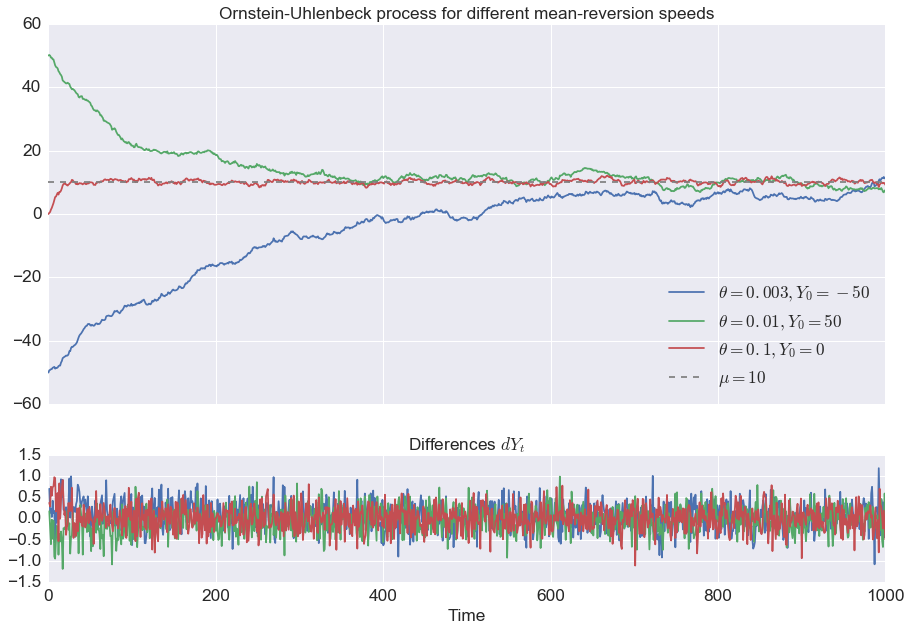

In [336]:
from matplotlib import gridspec

plt.figure(1, figsize=(15, 10))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
ax = plt.subplot(gs[0])
# plt.subplot(211)

# f, (a0, a1) = plt.subplots(2, 1, gridspec_kw = {'height_ratios':[2, 1]})
# a0.plot(Y_t1)
# a0.plot(Y_t2)
# a0.plot(Y_t3)
# a0.axhline(mu, color='grey', linestyle='--') 
_ = Y_t1.plot()
_ = Y_t2.plot()
_ = Y_t3.plot()
_ = plt.axhline(mu, color='grey', linestyle='--') 

# _ = plt.ylabel('Series Value')
plt.title('Ornstein-Uhlenbeck process for different mean-reversion speeds')
plt.legend([r'$\theta={0}, Y_0={1:0.0f}$'.format(theta1, Y_t1[0]), 
            r'$\theta={0}, Y_0={1:0.0f}$'.format(theta2, Y_t2[0]),
            r'$\theta={0}, Y_0={1:0.0f}$'.format(theta3, Y_t3[0]),
            r'$\mu={0}$'.format(mu)],
           loc='lower right')

# # plt.subplot(212)
plt.subplot(gs[1], sharex=ax)
plt.title('Differences $dY_t$')
Y_t1.diff().plot()
Y_t2.diff().plot()
Y_t3.diff().plot()
plt.xlabel('Time')

## Tests

We require a more robust method to confirm statistically whether a series is stationary than just by intuition. Several tests exist, such as:

* Augmented-Dickey Fuller (ADF) test
* Hurst exponent
* Goodness of fit to Ornstein–Uhlenbeck process
* Kalman filters

Here we just cover the ADF test below.

### Augmented Dickey-Fuller (ADF)

The _Dickey-Fuller test_ tests the null hypothesis of whether a unit root is present in the autoregressive model of the time series (also known as AR(p) where _p_ is the lag order, see Appendix). 

For example, for AR(1):

$$
Y_t = \beta Y_{t-1} + \epsilon_t
$$

If $\beta=1$ the series has a 'unit root' and is hence non-stationary. The equation can be rewriten as:

$$
\Delta Y_t = (\beta - 1) Y_{t-1} + \epsilon_t = \phi Y_{t-1} + \epsilon_t
$$

where $\phi= \beta-1$. Hence, testing for unit root is equivalent to testing $\phi=0$. 

The value of the test statistic $\hat{\phi}/std.err(\hat{\phi})$ is then compared to the relevant critical values for the Dickey-Fuller distribution. If found lower, then the null hypothesis $\phi=0$ is rejected and the series can be considered stationary.

To 'augmented' version increases the significance of the test by including lag terms $\sum_k^p \phi_k \Delta Y_{t-k}$.  This however requires the estimation of the _optimal lag order p_. The approach used here was by selecting the order which results in the lowest  _Akaike Information Criterion_ (AIC) (see Appendix), although other approaches exist. 

In addition, a _stability check_ can be done by ensuring the eigenvalues of the coefficients in the model lie within the 'unit circle' (see Appendix).

Other versions of the ADF test include drift and time-dependence terms, but these were not considered here - in practice the drift is often assumed zero  as it is usually smaller than any short-term fluctuations. Additional details on this topic can be found in [wiki ADF](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test), [wiki DF](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test), [wiki AR(p)](https://en.wikipedia.org/wiki/Autoregressive_model) and the Appendix.

### Python implementation

Clearly the above equations belong to the family of generalised linear models, which means the parameters can be estimated using the familiar linear regression methods (see Appendix). The self-implementation of the ADF test, AR(p) model, stability checks and optimal lag selection can be found in the python script _analysis.py_. These were validated against the popular python [statsmodels](http://statsmodels.sourceforge.net/) library equivalents. 

Taking the OU processes generated above, we first imply the optimal lag order for each. We then apply the ADF test using the optimal lag. The stability check is done on the coefficients vector (see Appendix). Lastly we compare the generated ADF statistic to the critical values to confirm or reject stationary.

#### Optimal Lag Selection


In practice, the choice of optimal lag is also evident from the Partial Autocorrelation Function (PACF) diagram: the significant serial autocorrelations will be above confidence limits.

By keeping more lags in Vector Autoregression you condition a model on them, thus making it prone to overfitting.

In [41]:
%run analysis.py

In [47]:
# self-implementation result, try 35 lags max
ou_list = [Y_t1, Y_t2, Y_t3]
my_lag_list = []
sm_lag_list = []

for Y_t in ou_list:
    
    my_bestlag , my_icbest = get_optimal_lag(Y_t, maxlag=35, model='adf')
    sm_result = adfuller(Y_t, maxlag=35, regression='nc', autolag='AIC', regresults=True)
    my_lag_list += [(Y_t.name, my_bestlag, my_icbest)]
    
    sm_bestlag = sm_result[3].usedlag
    sm_icbest = sm_result[3].icbest    
    sm_lag_list += [(Y_t.name, sm_bestlag, sm_icbest)]

print my_lag_list
print sm_lag_list

[('Y_t1', 1, -2.3144198629777843), ('Y_t2', 12, -2.4043608185924055), ('Y_t3', 28, -2.4525112867146639)]
[('Y_t1', 1L, 498.58152224535729), ('Y_t2', 10L, 415.36145608471702), ('Y_t3', 6L, 358.82645878570679)]


In practice, the choice of optimal lag is also evident from the Partial Autocorrelation Function (PACF) diagram: the significant serial autocorrelations will be above confidence limits.

By keeping more lags in Vector Autoregression you condition a model on them, thus making it prone to overfitting.

In [45]:
# self-implementation result, try 35 lags max
ou_list = [Y_t1, Y_t2, Y_t3]
my_lag_list = []
sm_lag_list = []

for Y_t in ou_list:
    
    my_bestlag , my_icbest = get_optimal_lag(Y_t.diff().dropna(), maxlag=35, model='adf')
    sm_result = adfuller(Y_t.diff().dropna(), maxlag=35, regression='nc', autolag='AIC', regresults=True)
    my_lag_list += [(Y_t.name, my_bestlag, my_icbest)]
    
    sm_bestlag = sm_result[3].usedlag
    sm_icbest = sm_result[3].icbest    
    sm_lag_list += [(Y_t.name, sm_bestlag, sm_icbest)]

print my_lag_list
print sm_lag_list

[('Y_t1', 26, -2.2934879092630909), ('Y_t2', 11, -2.3900939501230956), ('Y_t3', 27, -2.4545536831001673)]
[('Y_t1', 5L, 520.92955999414266), ('Y_t2', 9L, 424.14132941927596), ('Y_t3', 5L, 357.51076960916066)]


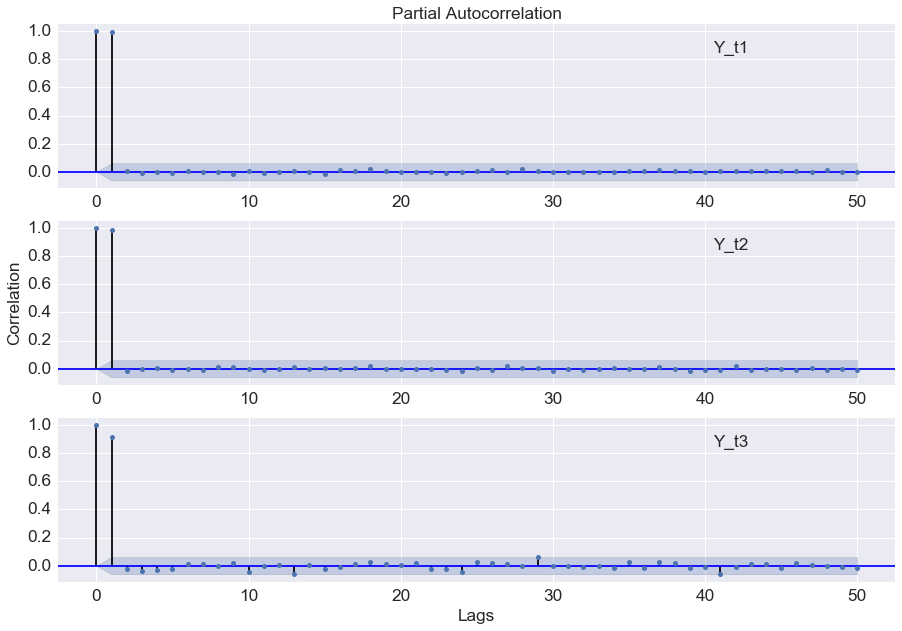

In [115]:
from matplotlib import gridspec
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(1, figsize=(15, 10))
gs = gridspec.GridSpec(3, 1)
# ax = plt.subplot(gs[0])


for i, ou in enumerate(ou_list):       
    ax = plt.subplot(gs[i])
    fig = plot_pacf(ou, lags=50, alpha=0.05, ax=ax)
    plt.text(x=40.5, y=0.85, s=ou.name, size='x-large')
    if i > 0:
        plt.title("")
#     if i < 2:  # set ticks to invisible
#         plt.xticks([])
#     if i == 1:
#         plt.ylabel("Correlation")
    if i == 2:
        plt.xlabel("Lags")

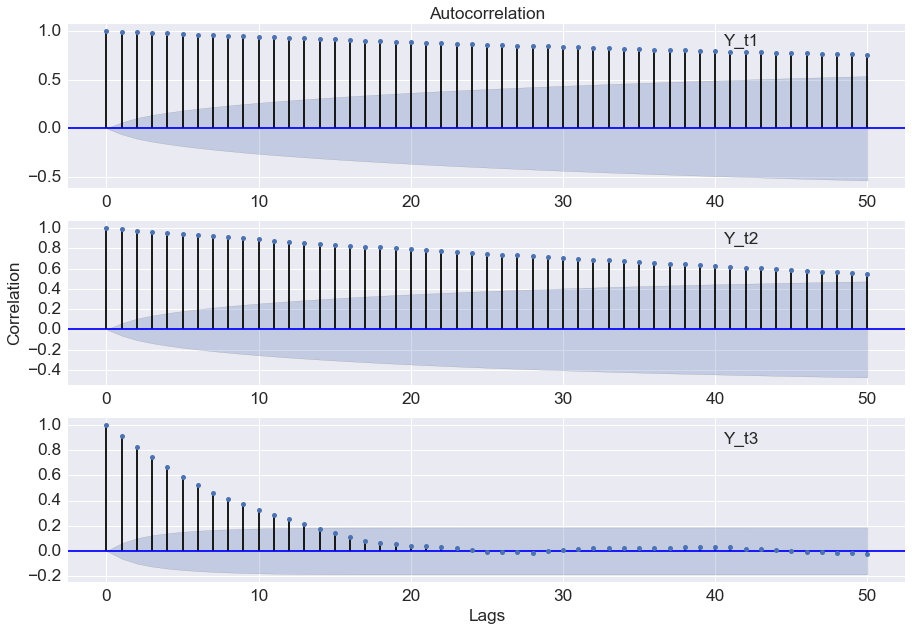

In [116]:
from matplotlib import gridspec
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(1, figsize=(15, 10))
gs = gridspec.GridSpec(3, 1)
# ax = plt.subplot(gs[0])


for i, ou in enumerate(ou_list):       
    ax = plt.subplot(gs[i])
    fig = plot_acf(ou, lags=50, alpha=0.05, ax=ax)
    plt.text(x=40.5, y=0.85, s=ou.name, size='x-large')
    if i > 0:
        plt.title("")
#     if i < 2:  # set ticks to invisible
#         plt.xticks([])
#     if i == 1:
#         plt.ylabel("Correlation")
    if i == 2:
        plt.xlabel("Lags")

In [14]:
# Statsmodel equivalent - 'nc' means 'no constant and no trend' included
sm_result = adfuller(x=Y_t1, maxlag=10, regression='nc', autolag='AIC', regresults=True)
sm_bestlag = sm_result[3].usedlag
sm_icbest1 = sm_result[3].icbest
sm_icbest2 = adfuller(x=Y_t1, maxlag=sm_bestlag, regression='nc', autolag=None, regresults=True)[3].resols.aic
print sm_bestlag, sm_icbest1, sm_icbest2

1 515.382312427 520.933746228


## Real Data Example

### Caveat - Regime changes